# **Load ChEMBL data**

In [1]:
# Install ChEMBL web service package
! pip install chembl_webresource_client

     |████████████████████████████████| 61kB 4.4MB/s 
  Created wheel for chembl-webresource-client: filename=chembl_webresource_client-0.10.2-cp37-none-any.whl size=55661 sha256=715eb96c5f80c9d267a5c4cbe2236f8d15bb9b748f0007c111a14dfff9017fca
  Stored in directory: /root/.cache/pip/wheels/e6/96/19/3f042bfda7c669bfe24c8278477f57b0fbbf3e488b4c09e3a8
Successfully built chembl-webresource-client


In [2]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [3]:
# Target search in ChEMBL database
target = new_client.target
target_query = target.search('VEGFR')
targets = pd.DataFrame.from_dict(target_query)
targets.head()

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Danio rerio,Vascular endothelial growth factor receptor 2,11.0,False,CHEMBL2331049,"[{'accession': 'Q5GIT4', 'component_descriptio...",SINGLE PROTEIN,7955
1,"[{'xref_id': 'FLT4', 'xref_name': None, 'xref_...",Homo sapiens,Vascular endothelial growth factor receptor 3,10.0,False,CHEMBL1955,"[{'accession': 'P35916', 'component_descriptio...",SINGLE PROTEIN,9606
2,"[{'xref_id': 'P35917', 'xref_name': None, 'xre...",Mus musculus,Vascular endothelial growth factor receptor 3,10.0,False,CHEMBL4758,"[{'accession': 'P35917', 'component_descriptio...",SINGLE PROTEIN,10090
3,[],Homo sapiens,Vascular endothelial growth factor receptor,10.0,False,CHEMBL2095227,"[{'accession': 'P17948', 'component_descriptio...",PROTEIN FAMILY,9606
4,[],Homo sapiens,Vascular endothelial growth factor receptor 2 ...,10.0,False,CHEMBL2111409,"[{'accession': 'P35916', 'component_descriptio...",SELECTIVITY GROUP,9606


In [4]:
# The first entry is what we need
selected_target = targets.target_chembl_id[1]
selected_target

'CHEMBL1955'

In [5]:
# Retrieve bioactivity data
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target) 

In [6]:
df = pd.DataFrame.from_dict(res)
print(df.shape)
df.head(3)

(3009, 45)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,34278,[],CHEMBL820215,Selectivity for Vascular endothelial growth fa...,B,None,None,BAO_0000179,BAO_0000357,single protein format,Cc1ccc(Nc2ncc(-c3ccccc3)s2)nc1,None,None,CHEMBL1146769,Bioorg. Med. Chem. Lett.,2004.0,None,CHEMBL330621,None,CHEMBL330621,None,False,None,185989,=,1,False,=,None,Selectivity,None,None,1.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,None,None,Selectivity,None,None,None,1.0
1,None,37864,[],CHEMBL820215,Selectivity for Vascular endothelial growth fa...,B,None,None,BAO_0000179,BAO_0000357,single protein format,Cc1ccnc(Nc2ncc(-c3ccccc3)s2)c1,None,None,CHEMBL1146769,Bioorg. Med. Chem. Lett.,2004.0,None,CHEMBL319065,None,CHEMBL319065,None,False,None,185988,=,1,False,=,None,Selectivity,None,None,2.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,None,None,Selectivity,None,None,None,2.0
2,None,40259,[],CHEMBL820215,Selectivity for Vascular endothelial growth fa...,B,None,None,BAO_0000179,BAO_0000357,single protein format,Cc1cccc(Nc2ncc(-c3ccccc3)s2)n1,None,None,CHEMBL1146769,Bioorg. Med. Chem. Lett.,2004.0,None,CHEMBL98385,None,CHEMBL98385,None,False,None,185990,=,1,False,=,None,Selectivity,None,None,3.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,None,None,Selectivity,None,None,None,3.0


In [7]:
file_name = selected_target+'_raw_data.csv'
df.to_csv(file_name, index=False)

# **Data Filtering**

In [8]:
df2 = pd.read_csv(file_name)
df2.shape

(3009, 45)

## **Target Organism = 'Homo Sapiens'**

In [9]:
# Check if the data only has target_organism=='Homo sapiens'
print(pd.unique(df2['target_organism']))

# Filter data by target_organism=='Homo sapiens'
df2=df2[df2['target_organism'].isin(['Homo sapiens'])]
print(pd.unique(df2['target_organism']))
df2.shape

['Homo sapiens']
['Homo sapiens']


(3009, 45)

## **Standard Type = 'IC50'**

In [10]:
# Check if the data only has standard_type=='IC50'
print(pd.unique(df2['standard_type']))

# Filter data by standard_type=='IC50'
df2=df2[df2['standard_type'].isin(['IC50'])]
print(pd.unique(df2['standard_type']))
df2.shape

['Selectivity' 'IC50' 'Inhibition' 'NI' 'Kd' 'Ki' 'Activity'
 'Residual activity' 'EC50' 'Residual Activity' 'INH' 'GI50' '% Control'
 '% residual kinase activity' '% Ctrl'
 '% Residual activity with Skepinone-L']
['IC50']


(553, 45)

##**Standard Unit = ['nM', 'uM', 'pM']**

In [11]:
print(pd.unique(df2['standard_units']))
# Filter data by units = ['nM','uM','pM']
units = ['nM','uM','pM']
df2=df2[df2['standard_units'].isin(units)].reset_index().drop(columns='index')

print(pd.unique(df2['standard_units']))
df2.shape

['nM' nan 'ug.mL-1']
['nM']


(525, 45)

In [12]:
file_name = selected_target+'_filtered_data.csv'
df2.to_csv(file_name, index=False)

# **Data Cleaning**


In [13]:
df3 = pd.read_csv(file_name)
df3.shape

(525, 45)

## **Drop Missing values**

* Drop missing SMILE notation
* Drop missing standard values


In [14]:
# Drop compounds with missing standard_value.
df3 = df3[df3['standard_value'].notna()]
print(df3.shape)

# Drop compounds with missing canonical_smiles column.
df3 = df3[df3['canonical_smiles'].notna()]
print(df3.shape)

# Reset index
df3 = df3.reset_index().drop(columns='index')
print(df3.shape)
df3.head(3)

(525, 45)
(525, 45)
(525, 45)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,506177,[],CHEMBL821012,Inhibition of Vascular endothelial growth fact...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,NaN,NaN,CHEMBL1135866,Bioorg. Med. Chem. Lett.,2002.0,"{'bei': '19.92', 'le': '0.37', 'lle': '2.17', ...",CHEMBL21156,NaN,CHEMBL21156,6.16,False,http://www.openphacts.org/units/Nanomolar,25954,=,1,True,=,NaN,IC50,nM,NaN,690.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.69
1,NaN,686001,[],CHEMBL820849,Inhibition of Vascular endothelial growth fact...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(O)C(/N=C1/C=C(O)/C(=N\C(C(=O)O)C(C)O)C=C1O)...,NaN,NaN,CHEMBL1145828,J. Med. Chem.,2003.0,"{'bei': '16.13', 'le': '0.31', 'lle': '6.09', ...",CHEMBL327725,NaN,CHEMBL327725,5.52,False,http://www.openphacts.org/units/Nanomolar,184695,=,1,True,=,NaN,IC50,nM,NaN,3000.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.00
2,NaN,750660,[],CHEMBL820850,Inhibition of Vascular endothelial growth fact...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,NaN,NaN,CHEMBL1148336,J. Med. Chem.,2004.0,NaN,CHEMBL115220,NaN,CHEMBL115220,NaN,False,http://www.openphacts.org/units/Nanomolar,215208,>,1,True,>,NaN,IC50,nM,NaN,10000.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,10000.00


## **Convert Standard Units (nM)**

In [15]:
#units = ['nM','uM','pM']

standard_unit_nM = []

for i,j in zip(df3['standard_units'],df3['standard_value']):
    if i == 'nM':
      standard_unit_nM.append(float(j))
    elif i == 'uM':
      standard_unit_nM.append(float(1000*float(j)))
    elif i == 'pM':
      standard_unit_nM.append(float(float(j)/1000))

In [16]:
#standard_unit_nM
standard_value_nM = pd.Series(standard_unit_nM, name='standard_value_nM')
print(standard_value_nM.shape)

(525,)


In [17]:
print(df3.shape)

df3 = pd.concat([df3, standard_value_nM], axis=1)
print(df3.shape)

# Sort data by ascending 'standard_unit_nM' values.
df3 = df3.sort_values('standard_value_nM',ascending=True).reset_index().drop(columns='index')
df3.head(3)
#df3[['standard_value','standard_units','standard_value_nM']].loc[(df3['standard_units']=='uM')].tail(5)

(525, 45)
(525, 46)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,standard_value_nM
0,NaN,18854179,[],CHEMBL4307052,Inhibition of VEGFR3 (unknown origin),B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,NaN,NaN,CHEMBL4304778,Eur J Med Chem,2019.0,"{'bei': '25.87', 'le': '0.49', 'lle': '5.36', ...",CHEMBL1289926,AXITINIB,CHEMBL1289926,10.0,False,http://www.openphacts.org/units/Nanomolar,3147182,=,1,True,=,NaN,IC50,nM,NaN,0.1,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,nM,UO_0000065,0.3,0.1,0.1
1,NaN,18784844,[],CHEMBL4271315,Inhibition of VEGFR3 (unknown origin),B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,NaN,NaN,CHEMBL4270503,Eur J Med Chem,2017.0,"{'bei': '25.87', 'le': '0.49', 'lle': '5.36', ...",CHEMBL1289926,AXITINIB,CHEMBL1289926,10.0,True,http://www.openphacts.org/units/Nanomolar,3121531,=,1,True,=,NaN,IC50,nM,NaN,0.1,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,nM,UO_0000065,0.3,0.1,0.1
2,NaN,16815391,[],CHEMBL3871603,Inhibition of VEGFR3 (unknown origin),B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,NaN,NaN,CHEMBL3871274,Eur J Med Chem,2016.0,"{'bei': '25.74', 'le': '0.49', 'lle': '5.75', ...",CHEMBL3939307,NaN,CHEMBL3939307,10.0,False,http://www.openphacts.org/units/Nanomolar,2811953,=,1,True,=,NaN,IC50,nM,NaN,0.1,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,nM,UO_0000065,0.3,0.1,0.1


## **Duplicated Compounds**

In [18]:
# Keep the one with minimum standard_value for duplicated ['compound_ID','target_ID']
df3 = df3.drop_duplicates(subset=['molecule_chembl_id','target_chembl_id'], keep='first').reset_index().drop(columns='index')
print(df3.shape)
df3.head(3)['standard_value_nM']

(452, 46)


0    0.1
1    0.1
2    0.2
Name: standard_value_nM, dtype: float64

##**Keep only useful columns**
#### **molecule_chembl_id, target_chembl_id, canonical_smiles, standard_value_nM**

In [19]:
# Combine columns ('molecule_chembl_id','target_chembl_id','canonical_smiles','standard_value_nM') and bioactivity_class into a DataFrame
selection = ['molecule_chembl_id','target_chembl_id','canonical_smiles','standard_value_nM']
df3 = df3[selection] #.rename(columns={'Molecule ChEMBL ID':'molecule_chembl_id','Smiles':'canonical_smiles','standard_unit_nM':'standard_value'})
print(df3.shape)
df3

(452, 4)


,molecule_chembl_id,target_chembl_id,canonical_smiles,standard_value_nM
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,0.10
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,0.10
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,0.20
3,CHEMBL1289494,CHEMBL1955,COc1cc2nccc(Oc3ccc(NC(=O)Nc4cc(C)on4)c(Cl)c3)c...,0.24
4,CHEMBL1940108,CHEMBL1955,COc1cccc(NC(=O)Cn2cc(Oc3ncnc4cc(OC)c(OC)cc34)c...,0.40
...,...,...,...,...
447,CHEMBL1668417,CHEMBL1955,COc1cc(O)c2c(c1)/C=C\CCCC(=O)C[C@H](Br)C[C@H](...,65000.00
448,CHEMBL3689078,CHEMBL1955,NC(=O)Cc1ccccc1CCc1nc(Nc2ccc(C3CCNCC3)cc2OC(F)...,66000.00
449,CHEMBL1668416,CHEMBL1955,COc1cc(O)c2c(c1)/C=C\CCCC(=O)C[C@H](Cl)C[C@H](...,100000.00
450,CHEMBL4446681,CHEMBL1955,CN(CCc1ccc(-c2ccccc2)cc1)Cc1cn(C)c2ccc(C(=O)Nc...,100000.00


In [20]:
file_name = selected_target+'_cleaned_data.csv'
df3.to_csv(file_name, index=False)

# **Labeling** 

In [21]:
import pandas as pd
df4 = pd.read_csv(file_name)
df4.shape

(452, 4)

## **Normalization (pIC50)**


In [22]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [23]:
def norm_value(input):
    norm = []

    for i in input['standard_value_nM']:
        #  Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value_nM', 1)
        
    return x

In [24]:
# Normalization
df5 = norm_value(df4)
df_norm = pIC50(df5)
df_norm.head(3) #.pIC50.describe()

,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,10.00000
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,10.00000
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,9.69897


In [25]:
botton_line = np.percentile(df4['standard_value_nM'], 20)
top_line = np.percentile(df4['standard_value_nM'], 80)
print(' 20-th =',botton_line,'\n','80-th =',top_line)

 20-th = 10.0 
 80-th = 4580.000000000001


In [26]:
botton_line = np.percentile(df_norm.pIC50, 20)
top_line = np.percentile(df_norm.pIC50, 80)
print(' 20-th =',botton_line,'\n','80-th =',top_line)

 20-th = 5.339151231899672 
 80-th = 8.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


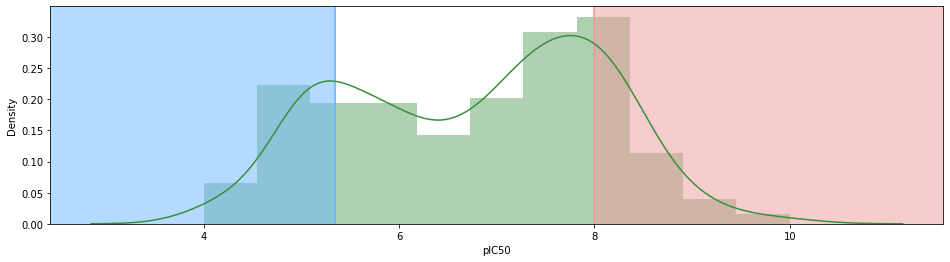

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#6DB6FF')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

#plotting the PDF
ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')

xlim = ax.get_xlim()
ax.axvspan(xlim[0], botton_line, color='#6DB6FF', alpha=0.5)
ax.axvspan(top_line, xlim[1], color='#EF9A9A', alpha=0.5)
#reset xlim
ax.set_xlim(xlim)
plt.show()

## **Labeling**

In [28]:
bioactivity_threshold = []
for i in df_norm.pIC50:
  if float(i) >= top_line:
    bioactivity_threshold.append(1)
  elif float(i) <= botton_line:
    bioactivity_threshold.append(0)
  else:
    bioactivity_threshold.append("intermediate")

In [29]:
# Combine the data
bioactivity_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df6 = pd.concat([df_norm, bioactivity_class], axis=1)
print(df6.shape)
df6.head(5)

(452, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,10.000000,1
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,10.000000,1
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,9.698970,1
3,CHEMBL1289494,CHEMBL1955,COc1cc2nccc(Oc3ccc(NC(=O)Nc4cc(C)on4)c(Cl)c3)c...,9.619789,1
4,CHEMBL1940108,CHEMBL1955,COc1cccc(NC(=O)Cn2cc(Oc3ncnc4cc(OC)c(OC)cc34)c...,9.397940,1


In [30]:
print(
    ' active',df6['bioactivity_class'][df6['bioactivity_class']==1].count(),'\n',
    'inactive',df6['bioactivity_class'][df6['bioactivity_class']==0].count(),'\n',
    'intermediate',df6['bioactivity_class'][df6['bioactivity_class']=="intermediate"].count()
)

 active 103 
 inactive 91 
 intermediate 258


In [31]:
file_name = selected_target+'_3cls_labeled_data.csv'
df6.to_csv(file_name, index=False)

## **Removing 'intermediate' class**

In [32]:
df_2class = df6[df6['bioactivity_class'] != 'intermediate']
print(df_2class.shape)
df_2class.head(3)

(194, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,10.00000,1
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,10.00000,1
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,9.69897,1


In [33]:
bi_file_name = selected_target+'_binary_2cls_labeled_data.csv'
df_2class.to_csv(bi_file_name, index=False)

#**(Multi-Labeled) Data Transformation**

##**Load existing mlc-data**

In [34]:
mlc_df = pd.read_csv('original_mlc_data.csv')

In [35]:
existing_targets_ls=[]
existing_targets_ls = list(mlc_df.columns[2:])
existing_targets_ls

['CHEMBL203', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL614725']

In [36]:
mlc_df[existing_targets_ls] = mlc_df[existing_targets_ls].astype('int')

print(mlc_df.shape)
mlc_df.head(2)

(5267, 6)


,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725
0,CHEMBL3645910,CCc1ncnc(-c2cc(F)c(C(=O)N3CCN4CCC[C@H]4C3)c(Cl...,0,0,1,0
1,CHEMBL558955,COC(=O)N1CCC(n2ncc3c(N4CCOCC4)nc(-c4ccc(NC(=O)...,0,0,1,0


In [37]:
new_df = pd.read_csv(bi_file_name)
print(new_df.shape)
new_df.head(3)

(194, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,10.00000,1
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,10.00000,1
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,9.69897,1


In [38]:
new_target = new_df.target_chembl_id[1]
existing_targets_ls.append(new_target)

selection = ['molecule_chembl_id','canonical_smiles','bioactivity_class']
new_df = new_df[selection].rename({'bioactivity_class': new_target}, axis='columns')
new_df.head(3)

,molecule_chembl_id,canonical_smiles,CHEMBL1955
0,CHEMBL1289926,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,1
1,CHEMBL3939307,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,1
2,CHEMBL1940109,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,1


In [39]:
multi_concat = pd.concat([mlc_df, new_df])

multi_dup_df = multi_concat[multi_concat.duplicated(['molecule_chembl_id'])]
multi_dup_df.tail(3)

,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
181,CHEMBL1957190,CC(C)n1c2c(c3c1-c1ccccc1C3=O)C(=O)CCC2,NaN,NaN,NaN,NaN,0.0
185,CHEMBL383264,N[C@H](COc1cncc(-c2ccc3cnccc3c2)c1)Cc1c[nH]c2c...,NaN,NaN,NaN,NaN,0.0
192,CHEMBL4446681,CN(CCc1ccc(-c2ccccc2)cc1)Cc1cn(C)c2ccc(C(=O)Nc...,NaN,NaN,NaN,NaN,0.0


##**Data Aggregation**

In [40]:
multi_res = multi_concat.groupby(['molecule_chembl_id','canonical_smiles']).agg({'CHEMBL203' : 'max', 'CHEMBL1957' : 'max', 'CHEMBL2842' : 'max', 'CHEMBL614725' : 'max', new_target : 'max'})

In [41]:
multi_res = multi_res.fillna(0).astype('int')

multi_res.insert(loc=0, column='canonical_smiles', value=multi_res.index.get_level_values('canonical_smiles'))
multi_res.insert(loc=0, column='molecule_chembl_id', value=multi_res.index.get_level_values('molecule_chembl_id'))

multi_res = multi_res.reset_index(drop=True)

multi_res

,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,0,0,0,0,0
1,CHEMBL101299,N[C@H]1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c5ccccc5o...,0,0,0,1,0
2,CHEMBL101871,C[C@]1([C@H]2Cc3ccc4oc5c(N6CC[C@H](N)C6)c(F)cc...,0,0,0,1,0
3,CHEMBL103667,Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCO...,0,0,0,0,0
4,CHEMBL104468,O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12,0,0,0,0,0
...,...,...,...,...,...,...,...
5425,CHEMBL9514,COC(=O)Nc1nc2ccc(C(=O)c3cccs3)cc2[nH]1,0,0,0,1,0
5426,CHEMBL96926,C/C=C(/C)C(=O)O[C@H]1C(C)=C2[C@@H]3OC(=O)[C@@]...,0,0,0,1,0
5427,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,0,0,0,1,0
5428,CHEMBL98137,COc1ccc(Nc2ccnc3cc(OC)c(OC)cc23)cc1OC,0,0,0,0,0


In [42]:
multi_res[multi_res.duplicated(['molecule_chembl_id'])].count()['molecule_chembl_id']

0

In [43]:
mul_file_name = selected_target+'_multi_2cls_labeled_data.csv'
multi_res.to_csv(mul_file_name, index=False)

##**Update original_mlc_data.csv**

In [44]:
multi_res.to_csv('original_mlc_data.csv')

# **Calculate PubChem fingerprint**

In [45]:
df_mul = pd.read_csv(mul_file_name)
print(df_mul.shape)
df_mul.tail(3)

(5430, 7)


,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
5427,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,0,0,0,1,0
5428,CHEMBL98137,COc1ccc(Nc2ccnc3cc(OC)c(OC)cc23)cc1OC,0,0,0,0,0
5429,CHEMBL98350,O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12,0,0,0,0,0


In [46]:
df_bi = pd.read_csv(bi_file_name)
print(df_bi.shape)
df_bi.tail(3)

(194, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
191,CHEMBL1668416,CHEMBL1955,COc1cc(O)c2c(c1)/C=C\CCCC(=O)C[C@H](Cl)C[C@H](...,4.0,0
192,CHEMBL4446681,CHEMBL1955,CN(CCc1ccc(-c2ccccc2)cc1)Cc1cn(C)c2ccc(C(=O)Nc...,4.0,0
193,CHEMBL1668412,CHEMBL1955,COc1cc(O)c2c(c1)/C=C/CCCC(=O)C[C@H](Cl)C[C@H](...,4.0,0


## **Download PaDEL-Descriptor**

In [47]:
! wget http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip

--2021-04-02 22:18:26--  http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip
Resolving www.yapcwsoft.com (www.yapcwsoft.com)... 118.189.195.172
Connecting to www.yapcwsoft.com (www.yapcwsoft.com)|118.189.195.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20875190 (20M) [application/zip]
Saving to: ‘PaDEL-Descriptor.zip’

PaDEL-Descriptor.zi 100%[===================>]  19.91M  5.15MB/s    in 5.0s    

2021-04-02 22:18:31 (3.98 MB/s) - ‘PaDEL-Descriptor.zip’ saved [20875190/20875190]



In [48]:
! unzip PaDEL-Descriptor.zip

Archive:  PaDEL-Descriptor.zip
  inflating: Descriptors.xls         
  inflating: descriptors.xml         
   creating: lib/
  inflating: lib/ambit2-base-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-core-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-smarts-2.4.7-SNAPSHOT.jar  
  inflating: lib/appframework-1.0.3.jar  
  inflating: lib/cdk-1.4.15.jar      
  inflating: lib/commons-cli-1.2.jar  
  inflating: lib/guava-17.0.jar      
  inflating: lib/jama.jar            
  inflating: lib/jgrapht-0.6.0.jar   
  inflating: lib/l2fprod-common-all.jar  
  inflating: lib/libPaDEL-Descriptor.jar  
  inflating: lib/libPaDEL-Jobs.jar   
  inflating: lib/libPaDEL.jar        
  inflating: lib/swing-worker-1.1.jar  
  inflating: lib/vecmath1.2-1.14.jar  
  inflating: lib/xom-1.1.jar         
   creating: license/
  inflating: license/lgpl-2.1.txt    
  inflating: license/lgpl.license    
  inflating: license/LICENSE.txt     
  inflating: license/README - CDK    
  inflating: PaDEL-Descriptor.jar    


In [49]:
# Modify the descriptors.xml file for calculation
import lxml.etree

# input
doc = lxml.etree.parse('descriptors.xml')
# modification
for el in doc.xpath("//Descriptor[@name!='PubchemFingerprinter']"):
  el.attrib['value'] = 'false'
# output
# open('output_file.xml', 'w').write(lxml.etree.tostring(doc))
doc.write('pubchemfingerprinter.xml')

## **Calculate Pubchem Fingerprints**

###**Binary**

In [50]:
selection = ['canonical_smiles','molecule_chembl_id']
df_bi_selection = df_bi[selection]
print(df_bi_selection.shape)
df_bi_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

(194, 2)


In [51]:
! cat molecule.smi | head -5

CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1	CHEMBL1289926
CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1	CHEMBL3939307
COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c2cc1OC	CHEMBL1940109
COc1cc2nccc(Oc3ccc(NC(=O)Nc4cc(C)on4)c(Cl)c3)c2cc1OC	CHEMBL1289494
COc1cccc(NC(=O)Cn2cc(Oc3ncnc4cc(OC)c(OC)cc34)cn2)c1	CHEMBL1940108


In [52]:
! cat molecule.smi | wc -l

194


In [53]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file binary_descriptors_output.csv

Processing CHEMBL1289926 in molecule.smi (1/194). 
Processing CHEMBL3939307 in molecule.smi (2/194). 
Processing CHEMBL1940109 in molecule.smi (3/194). Average speed: 3.54 s/mol.
Processing CHEMBL1289494 in molecule.smi (4/194). Average speed: 1.80 s/mol.
Processing CHEMBL1940108 in molecule.smi (5/194). Average speed: 1.52 s/mol.
Processing CHEMBL1668411 in molecule.smi (6/194). Average speed: 1.17 s/mol.
Processing CHEMBL1173411 in molecule.smi (8/194). Average speed: 0.91 s/mol.
Processing CHEMBL2012519 in molecule.smi (7/194). Average speed: 1.06 s/mol.
Processing CHEMBL388978 in molecule.smi (9/194). Average speed: 0.85 s/mol.
Processing CHEMBL495727 in molecule.smi (10/194). Average speed: 0.77 s/mol.
Processing CHEMBL3891581 in molecule.smi (11/194). Average speed: 0.75 s/mol.
Processing CHEMBL4453304 in molecule.smi (12/194). Average speed: 0.75 s/mol.
Processing CHEMBL2180604 in molecule.smi (13/194). Average speed: 0.78 s/mol.
Processing CHEMBL4303275 in molecule.smi (14/194)

In [54]:
! ls -l

total 24872
-rw-r--r-- 1 root root   356205 Apr  2 22:19 binary_descriptors_output.csv
-rw-r--r-- 1 root root    47589 Apr  2 22:17 CHEMBL1955_3cls_labeled_data.csv
-rw-r--r-- 1 root root    18597 Apr  2 22:17 CHEMBL1955_binary_2cls_labeled_data.csv
-rw-r--r-- 1 root root    39392 Apr  2 22:12 CHEMBL1955_cleaned_data.csv
-rw-r--r-- 1 root root   386224 Apr  2 22:12 CHEMBL1955_filtered_data.csv
-rw-r--r-- 1 root root   439380 Apr  2 22:17 CHEMBL1955_multi_2cls_labeled_data.csv
-rw-r--r-- 1 root root  1549907 Apr  2 22:06 CHEMBL1955_raw_data.csv
-rw-r--r-- 1 root root   957952 Jun 26  2014 Descriptors.xls
-rw-r--r-- 1 root root     4669 Jun 13  2014 descriptors.xml
drwxr-xr-x 2 root root     4096 Jul 21  2014 lib
drwxr-xr-x 2 root root     4096 May  8  2012 license
-rw-r--r-- 1 root root    13428 Apr  2 22:18 molecule.smi
-rw-r--r-- 1 root root   465421 Apr  2 22:17 original_mlc_data.csv
-rw-r--r-- 1 root root   268084 Jul 21  2014 PaDEL-Descriptor.jar
-rw-r--r-- 1 root root 20875190 Jul

In [55]:
bi_df_fp = pd.read_csv('binary_descriptors_output.csv')
bi_df_fp = bi_df_fp.rename({'Name': 'molecule_chembl_id'}, axis='columns')
print(bi_df_fp.shape)
bi_df_fp.tail(3)

(194, 882)


,molecule_chembl_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
191,CHEMBL3689078,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192,CHEMBL1668412,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193,CHEMBL4446681,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
bi_df_all = pd.merge(df_bi,bi_df_fp, on="molecule_chembl_id")
print(bi_df_all.shape)
bi_df_all.tail(3)

(194, 886)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
191,CHEMBL1668416,CHEMBL1955,COc1cc(O)c2c(c1)/C=C\CCCC(=O)C[C@H](Cl)C[C@H](...,4.0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192,CHEMBL4446681,CHEMBL1955,CN(CCc1ccc(-c2ccccc2)cc1)Cc1cn(C)c2ccc(C(=O)Nc...,4.0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193,CHEMBL1668412,CHEMBL1955,COc1cc(O)c2c(c1)/C=C/CCCC(=O)C[C@H](Cl)C[C@H](...,4.0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
binary_fp_file_name = selected_target+'_binary_FP_all_data.csv'
bi_df_all.to_csv(binary_fp_file_name, index=False)

###**Multi_Labeled**

In [58]:
selection = ['canonical_smiles','molecule_chembl_id']
df_mul_selection = df_mul[selection]
print(df_mul_selection.shape)
df_mul_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

(5430, 2)


In [59]:
! cat molecule.smi | head -5

C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1	CHEMBL10
N[C@H]1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c5ccccc5oc2c34)C1	CHEMBL101299
C[C@]1([C@H]2Cc3ccc4oc5c(N6CC[C@H](N)C6)c(F)cc6c(=O)c(C(=O)O)cn(c4c3O2)c56)CO1	CHEMBL101871
Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCOCC3)c3ccccc23)cc1	CHEMBL103667
O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12	CHEMBL104468


In [60]:
! cat molecule.smi | wc -l

5430


In [61]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file multi_descriptors_output.csv

Streaming output truncated to the last 5000 lines.
Processing CHEMBL1762162 in molecule.smi (431/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762165 in molecule.smi (434/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762164 in molecule.smi (433/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762166 in molecule.smi (435/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762178 in molecule.smi (436/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762180 in molecule.smi (437/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762181 in molecule.smi (438/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762182 in molecule.smi (439/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762341 in molecule.smi (441/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762340 in molecule.smi (440/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762342 in molecule.smi (442/5430). Average speed: 0.28 s/mol.
Processing CHEMBL1762343 in molecule.smi (443/5430). Average speed: 0

In [62]:
! ls -l

total 35036
-rw-r--r-- 1 root root   356205 Apr  2 22:19 binary_descriptors_output.csv
-rw-r--r-- 1 root root    47589 Apr  2 22:17 CHEMBL1955_3cls_labeled_data.csv
-rw-r--r-- 1 root root    18597 Apr  2 22:17 CHEMBL1955_binary_2cls_labeled_data.csv
-rw-r--r-- 1 root root   371772 Apr  2 22:19 CHEMBL1955_binary_FP_all_data.csv
-rw-r--r-- 1 root root    39392 Apr  2 22:12 CHEMBL1955_cleaned_data.csv
-rw-r--r-- 1 root root   386224 Apr  2 22:12 CHEMBL1955_filtered_data.csv
-rw-r--r-- 1 root root   439380 Apr  2 22:17 CHEMBL1955_multi_2cls_labeled_data.csv
-rw-r--r-- 1 root root  1549907 Apr  2 22:06 CHEMBL1955_raw_data.csv
-rw-r--r-- 1 root root   957952 Jun 26  2014 Descriptors.xls
-rw-r--r-- 1 root root     4669 Jun 13  2014 descriptors.xml
drwxr-xr-x 2 root root     4096 Jul 21  2014 lib
drwxr-xr-x 2 root root     4096 May  8  2012 license
-rw-r--r-- 1 root root   384988 Apr  2 22:19 molecule.smi
-rw-r--r-- 1 root root  9664339 Apr  2 22:40 multi_descriptors_output.csv
-rw-r--r-- 1 ro

In [63]:
multi_df_fp = pd.read_csv('multi_descriptors_output.csv')
multi_df_fp = multi_df_fp.rename({'Name': 'molecule_chembl_id'}, axis='columns')
print(multi_df_fp.shape)
multi_df_fp.tail(3)

(5430, 882)


,molecule_chembl_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
5427,CHEMBL98137,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5428,CHEMBL96926,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5429,CHEMBL98350,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
multi_df_all = pd.merge(df_mul,multi_df_fp, on="molecule_chembl_id")
print(multi_df_all.shape)
multi_df_all.tail(3)

(5430, 888)


,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
5427,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5428,CHEMBL98137,COc1ccc(Nc2ccnc3cc(OC)c(OC)cc23)cc1OC,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5429,CHEMBL98350,O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
multi_fp_file_name = selected_target+'_multi_FP_all_data.csv'
multi_df_all.to_csv(multi_fp_file_name, index=False)

# **Preparing the X and Y data matrices**

##**Binary**

In [66]:
df8 = pd.read_csv(binary_fp_file_name)
df8.shape

(194, 886)

### **X data matrix**

In [67]:
selection = ['molecule_chembl_id','target_chembl_id','canonical_smiles','pIC50','bioactivity_class']

In [68]:
df_X = df8.drop(columns=selection)
print(df_X.shape)
df_X.tail(3)

(194, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
191,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Y variable**

In [69]:
df_Y = df8.bioactivity_class

### **Dataset for Modeling**

In [70]:
df9 = pd.concat([df_Y,df_X], axis=1)
print(df9.shape)
df9.tail(3)

(194, 882)


,bioactivity_class,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
191,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
192,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
binary_dataset_filename = selected_target+'_Binary_modeling_dataset.csv'
df9.to_csv(binary_dataset_filename, index=False)

## **Multi-labeled**

In [72]:
df10 = pd.read_csv(multi_fp_file_name)
df10.shape

(5430, 888)

### **X data matrix**

In [73]:
adds = ['molecule_chembl_id','canonical_smiles']

In [74]:
selections = existing_targets_ls + adds

In [75]:
df_X = df10.drop(columns=selections)
print(df_X.shape)
df_X.tail(3)

(5430, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
5427,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5428,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5429,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Y variable**

In [76]:
df_Y = df10[existing_targets_ls]
print(df_Y.shape)
df_Y.tail(3)

(5430, 5)


,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
5427,0,0,0,1,0
5428,0,0,0,0,0
5429,0,0,0,0,0


### **Dataset for Modeling**

In [77]:
df11 = pd.concat([df_Y,df_X], axis=1)
print(df11.shape)
df11.head(3)

(5430, 886)


,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
multi_dataset_filename = selected_target+'_Multi_modeling_dataset.csv'
df11.to_csv(multi_dataset_filename, index=False)

In [79]:
#multi_dataset_filename = selected_target+'_Multi_modeling_dataset.csv'

In [80]:
#binary_dataset_filename = selected_target+'_Binary_modeling_dataset.csv'

#**Modeling - Multi-labeled**

In [83]:
df = pd.read_csv(multi_dataset_filename)
df.head(2)

,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
print(existing_targets_ls)
df_X = df.drop(columns=existing_targets_ls)
df_X.head(2)

['CHEMBL203', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL614725', 'CHEMBL1955']


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
df_Y = df[existing_targets_ls]
df_Y.head(2)

,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
0,0,0,0,0,0
1,0,0,0,1,0


## **Split 80/20**

In [88]:
from sklearn.model_selection import train_test_split

In [103]:
y_train, y_test, X_train, X_test = train_test_split(df_Y, df_X, test_size=0.2)

In [104]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4344, 881), (4344, 5), (1086, 881), (1086, 5))

In [109]:
X_train.to_csv('multi_X_train.csv', index=False)
X_test.to_csv('multi_X_test.csv', index=False)
y_train.to_csv('multi_y_train.csv', index=False)
y_test.to_csv('multi_y_test.csv', index=False)

## **Decision Tree**

In [110]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [111]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [114]:
dt_predictions = dt_classifier.predict(X_test)
print(dt_predictions.shape)
dt_predictions

(1086, 5)


array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [117]:
dt_acc = accuracy_score(y_test,dt_predictions)
print("Accuracy = ",dt_acc)

Accuracy =  0.8692449355432781


##**LSTM**

### **Model Preparation**

In [118]:
from tensorflow.keras import regularizers

In [119]:
def lstm_model(n_features, n_outputs):
    model = Sequential()
    model.add(Bidirectional(LSTM(1000, activation='relu', return_sequences=True), input_shape=(1, n_features)))
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True)))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

### **Input Preparation**

In [122]:
n_inputs, n_outputs = df_X.shape[1], df_Y.shape[1]

In [123]:
n_samples = len(X_train)
n_features = n_inputs
train_X = X_train.to_numpy().reshape(n_samples, 1, n_features)
train_y = y_train.to_numpy()

###**Model Fitting**

In [125]:
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization, Flatten

In [126]:
lstm_mod = lstm_model(n_inputs, n_outputs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 2000)           15056000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 1000)           10004000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 1000)           6004000   
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

In [127]:
history = lstm_mod.fit(train_X, train_y, epochs=100)

Epoch 1/100
136/136 [==============================] - 52s 326ms/step - loss: 0.3498 - accuracy: 0.6285
Epoch 2/100
136/136 [==============================] - 44s 323ms/step - loss: 0.1272 - accuracy: 0.6137
Epoch 3/100
136/136 [==============================] - 44s 322ms/step - loss: 0.0995 - accuracy: 0.6530
Epoch 4/100
136/136 [==============================] - 44s 323ms/step - loss: 0.0708 - accuracy: 0.6551
Epoch 5/100
136/136 [==============================] - 44s 325ms/step - loss: 0.0686 - accuracy: 0.6544
Epoch 6/100
136/136 [==============================] - 44s 325ms/step - loss: 0.0503 - accuracy: 0.6642
Epoch 7/100
136/136 [==============================] - 44s 325ms/step - loss: 0.0479 - accuracy: 0.6028
Epoch 8/100
136/136 [==============================] - 45s 328ms/step - loss: 0.0422 - accuracy: 0.6891
Epoch 9/100
136/136 [==============================] - 44s 323ms/step - loss: 0.0371 - accuracy: 0.6379
Epoch 10/100
136/136 [==============================] - 44s 323m

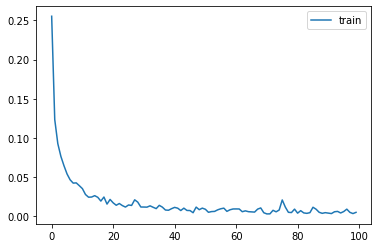

In [129]:
# plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

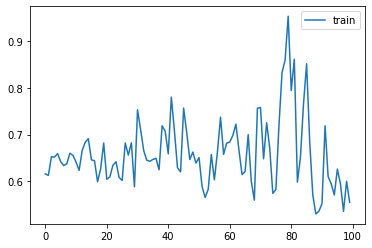

In [131]:
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show()

###**Prediction**

In [210]:
n_samples_test = len(X_test)
n_features = n_inputs
lstm_test_X = X_test.to_numpy().reshape(n_samples_test, 1, n_features)

In [211]:
lstm_predictions = lstm_mod.predict(lstm_test_X)

lstm_predictions[lstm_predictions > 0.5] = 1
lstm_predictions[lstm_predictions <= 0.5] = 0
lstm_predictions

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [134]:
lstm_acc = accuracy_score(y_test,lstm_predictions)
print("Accuracy = ",lstm_acc)

Accuracy =  0.9208103130755064


##**Baseline Neural Network**

In [135]:
n_inputs, n_outputs = df_X.shape[1], df_Y.shape[1]

###**PCA (Optional)**

In [139]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random

In [136]:
def transform_data(X_arg, n):
    print("transform_data is called", n)
    svd = TruncatedSVD(n_components=int(n - 1), n_iter=7, random_state=42)
    tr_X = svd.fit(X_arg)
    X_vals = tr_X.transform(X_arg)
    
    X_vals = pd.DataFrame(X_vals)
    print(X_vals.shape)
    return X_vals, n - 1

In [140]:
X_features, n_inputs_pca = transform_data(df_X, df_X.shape[1])

transform_data is called 881
(5430, 880)


In [141]:
# Sparsity after transformation

a = (X_features.to_numpy() == 0).mean()
print("Sparsity of fingerprints data is {}".format(a))

Sparsity of fingerprints data is 0.0172356855851331


###**Model Fitting**

In [142]:
def get_model_baseline(n_inputs, n_outputs ):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(20, input_dim=n_inputs,  kernel_initializer='he_uniform', activation='relu'))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    #model.add(tf.keras.layers.LSTM(300, activation='relu'))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='sigmoid'))
    model.compile( loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    return model

In [149]:
from keras.layers import Dropout
bs_x_train, bs_Y_train = np.array(X_train), np.array(y_train)

#Reshape the data into 3-D array
#bs_x_train = np.reshape(bs_x_train, (bs_x_train.shape[0],bs_x_train.shape[1], 1))
#bs_x_train.shape

(4344, 881, 1)

In [150]:
import tensorflow as tf 

In [147]:
bs_mod = get_model_baseline(n_inputs, n_outputs)

In [152]:
history = bs_mod.fit(X_train, y_train, epochs=200)

Epoch 1/200
136/136 [==============================] - 1s 5ms/step - loss: 0.0058 - accuracy: 0.6229 - auc: 0.9999
Epoch 2/200
136/136 [==============================] - 1s 5ms/step - loss: 0.0055 - accuracy: 0.6499 - auc: 1.0000
Epoch 3/200
136/136 [==============================] - 1s 5ms/step - loss: 0.0041 - accuracy: 0.6420 - auc: 0.9999
Epoch 4/200
136/136 [==============================] - 1s 5ms/step - loss: 0.0045 - accuracy: 0.6363 - auc: 0.9999
Epoch 5/200
136/136 [==============================] - 1s 5ms/step - loss: 0.0157 - accuracy: 0.6443 - auc: 0.9981
Epoch 6/200
136/136 [==============================] - 1s 5ms/step - loss: 0.0075 - accuracy: 0.6204 - auc: 0.9997
Epoch 7/200
136/136 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 0.6404 - auc: 1.0000
Epoch 8/200
136/136 [==============================] - 1s 5ms/step - loss: 0.0032 - accuracy: 0.6188 - auc: 0.9998
Epoch 9/200
136/136 [==============================] - 1s 5ms/step - loss: 0.003

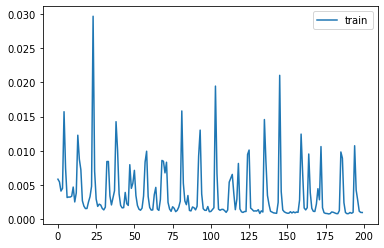

In [153]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

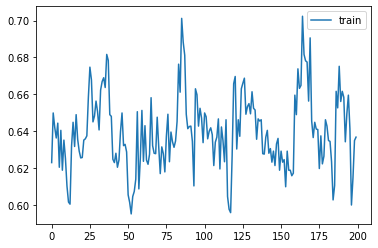

In [154]:
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show()

###**Prediction**

In [212]:
#bs_x_test = np.array(X_test)

#Reshape the data into 3-D array
#bs_x_test = np.reshape(bs_x_test, (bs_x_test.shape[0],bs_x_test.shape[1],1))

In [214]:
bs_predictions = bs_mod.predict(X_test)

bs_predictions[bs_predictions > 0.5] = 1
bs_predictions[bs_predictions <= 0.5] = 0
bs_predictions

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [156]:
base_acc = accuracy_score(y_test,bs_predictions)
print("Accuracy = ",base_acc)

Accuracy =  0.8830570902394107


##**Model Comparison & Save .h5 file**

In [220]:
multi_mods_acc = {'dt_classifier': dt_acc,'lstm_mod':lstm_acc,'bs_mod': base_acc}
multi_mods = {'dt_classifier': dt_classifier,'lstm_mod':lstm_mod,'bs_mod': bs_model}

In [221]:
selected_multi_model = max(multi_mods_acc, key=multi_mods_acc.get)
selected_multi_model

'lstm_mod'

In [222]:
import h5py 
from sklearn.externals import joblib

In [223]:
if selected_multi_model.find('_mod'):
  file_name = selected_target+'_M_'+selected_multi_model+'.h5'
  selected_model = multi_mods.get(selected_multi_model)
  selected_model.save(file_name)
else :
  file_name = selected_target+'_M_'+selected_multi_model+'.pkl'
  joblib.dump(multi_mods.get(selected_multi_model), file_name)

#**Modeling - Binary**